# Assingment #4

## Part2 Stitching images (90 points):

In an iPython notebook stitching.ipynb, import the following

```python
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 # yes, you can do this, but see below!
```

Go outside the science library onto the grass and take **10 pictures** of the campus,
taking care that each picture overlaps with the other, but that you also cover some
large area. The pictures need to be submitted with your assignment, of course.

Then implement the full stitching pipeline using a nice set of functions. 
Each function is described below – the input and output parameters should be clear:

`loadImages`: Load images, convert them to double and to grayscale. Return list of
images.

`getFeaturePoints`: Detect feature points in an image, using the (Harris) corner
detector you developed in Assignment 3. Save them in a list and return. The function
should also plot the detected feature points in the image.

`getFeatureDescriptors`: For a given input list of feature points, extract its
neighborhood using the pixel values in a small window around each point as a feature
vector. The window size needs to be a parameter of the function. Return the feature
vectors as another list.

`match2Images`: Given lists of feature points and feature descriptors from two
images, match them. For this, compute distances between every descriptor in one
image and every descriptor in the other image – Euclidean distance may work, but
more robust matching can be done with normalized cross correlation (look it up, it’s
easy!) of the descriptors. Implement both ways and check later which gives better
results. Select matches based on the ratio criterion with a suitable threshold (this is a
function parameter). The function should also plot the matches between the two
images. Return the matches as a list of indices in the two images.

`refineMatches`: Given lists of feature points and the match list, implement
RANSAC to estimate a homography mapping one image onto the other (so, the full
number of 8 parameters). In each iteration of RANSAC, simply select 4 points at
random, estimate the homography by finding the nullspace of the transform (see
lecture 6!). This function also needs parameters for inlier thresholds and rounds of
iterations with which you need to experiment. Return the estimated homography.
When running the function, it should print out the number of inliers that survive
RANSAC and the average residual for the inliers (squared distance between the point
coordinates in one image and the transformed coordinates of the matching point in
the other image). Finally, the function should plot the surviving matches.

`warpImages`: given a list of homographies and a list of n images, warp images 2-n
onto the image space of image 1. For this, you are allowed to use the OpenCV
function warpPerspective, which will work with your estimated homography
(take care though in which direction you estimated the homography!!). In the
function you will need to first create a new image big enough to hold all stitched
images and then use warpPerspective to composite the two images into it. Use
averaging of pixels for the stitching. Return the full stitched image and have the
function also plot the result.

**Implement all functions with nice commenting, and experiment with parameters
of the functions such that they work, also make notes of your experiments and
explain your choice of parameter in the iPython-notebook!**

Tips:
- Make sure that the images have enough overlap, otherwise our very simple
feature descriptors may not work
- I would recommend to also resize the images, so that they are maximum of
1000x800 or something similar – if you use too high-res images, this pipeline
will get too slow
- You can and should sanity check your steps by using the inbuilt OpenCV
functions for Harris detectors and/or ORB features as well as RANSAC
matching the important functions for this would be [ORB_create,
detectAndCompute; BFMatcher_create, match].
- **If you cannot make your own version to work, please include at least a
version that does the job with OpenCV – if you do this the assignment will
only be worth 30 points.**

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 # yes, you can do this, but see below!

import os
from os.path import isfile, join
from tqdm.auto import tqdm
from PIL import Image
import sys
from multiprocessing import Pool, cpu_count
from functools import partial

%matplotlib inline

## loadImages

In [2]:
def rgb2gray(rgb):
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return gray

In [3]:
def loadImages(path):
    frame_array = []
    files = [f for f in os.listdir(path) if isfile(join(path, f))]
    files.sort()
    
    for i in range(len(files)):
        filename = path + files[i]
        #reading each files
        img = plt.imread(filename)
        img = rgb2gray(img)
    
        #inserting the frames into an image array
        frame_array.append(img)
    
    return frame_array

In [4]:
def img_resize(pathIn, pathOut):
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files.sort()
    
    if not os.path.exists(pathOut):
        os.makedirs(pathOut)
    else:
        print(pathOut + " has been processed!")
    
    for i in range(len(files)):
        filename = pathIn + files[i]
        #reading each files
        img = Image.open(filename)
        img = img.resize((int(img.size[0]/4), int(img.size[1]/4)))
        
        img.save(f"{pathOut}{files[i]}.png",'png')

In [5]:
img_resize('./image/images_01/', './image/rimages_01/')

./image/rimages_01/ has been processed!


## getFeaturePoints

In [44]:
def convolution(img: np.array, weights: np.array):
    """
    Convolution with weights filter
    
    Arguments
    ---------
    - img      : image
    - weights  : filter weights
    
    Return
    ------
    - filtered : filtered image
    
    """
    weights = weights.astype(float)
    filtered = np.zeros_like(img)
    
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]=np.sum(weights*img[j-width:j+width+1,i-height:i+height+1])
            
    return filtered

def cornerDetect(img: np.array, winSize: int = 7, type: int = 0):
    """
    Corner Detection
    
    Arguments
    ---------
    - img     : image # we are only doing grayscale images,
    - winSize : total size of window for summation in pixels,
    - type    : {0 – Eigenvalue, 1 – Harris}
    
    Return
    ------
    - l1      : detected corner array by Eigenvalue
    - h       : detected corner array by Herris
    """
    
    # sobel filter by axis
    filter_sobelx = np.array([
        (-1,0,1),
        (-2,0,2),
        (-1,0,1)
    ])
    filter_sobely = np.array([
        (-1,-2,-1),
        (0,0,0),
        (1,2,1)
    ])
    
    # convolution
    imgdx = convolution(img, 1/8*filter_sobelx)
    imgdy = convolution(img, 1/8*filter_sobely)
    
    # define array
    corner = np.zeros_like(img)
    
    # Ixx, Iyy, Ixy
    ix2 = imgdx*imgdx
    iy2 = imgdy*imgdy
    ixy = imgdx*imgdy
    
    # calcuate Eigenvalue and Herris by window
    for y in range(0+winSize, img.shape[0]-1-winSize):
        for x in range(0+winSize, img.shape[1]-1-winSize):
            sx2 = np.sum(ix2[y-winSize:y+winSize, x-winSize:x+winSize])
            sy2 = np.sum(iy2[y-winSize:y+winSize, x-winSize:x+winSize])
            sxy = np.sum(ixy[y-winSize:y+winSize, x-winSize:x+winSize])
            
            # H
            tmpH = np.array([(sx2,sxy), (sxy,sy2)])

            if type==0:
                # Eigenvalues
                corner[y,x], _ = np.sort(np.linalg.eigvals(tmpH))
            elif type==1:
                # Herris
                ttmp = np.trace(tmpH)
                if ttmp != 0:
                    corner[y,x] = np.linalg.det(tmpH)/ttmp
            
    return corner          

In [45]:
def getFeaturePoints_(image, winSize, threshold):
    """
    Detect feature points in an image, using the Harris corner detector
    
    Arguments
    ---------
    - images    : images # we are only doing grayscale images,
    - winSize   : total size of window for summation in pixels,
    - threshold : threshold for best corners 
    
    Return
    ------
    - corners   : detected corners array by Herris
    """
    
    herris_cor = cornerDetect(image, winSize, type=1) > threshold
    fp = np.argwhere(herris_cor==True)
    
    return fp

In [46]:
def getFeaturePoints(images, winSize: int = 5, threshold: float = 0.8, workers=None, plot=False):
    """
    Detect feature points in an image, using the Harris corner detector
    
    Arguments
    ---------
    - images    : images # we are only doing grayscale images,
    - winSize   : total size of window for summation in pixels,
    - threshold : threshold for best corners 
    
    Return
    ------
    - corners   : detected corners array by Herris
    """
    
    with Pool(workers or cpu_count()) as pool:
        result = list(tqdm(pool.imap(
            func=partial(getFeaturePoints_, winSize=winSize, threshold=threshold),
            iterable=images
        ), total=len(images)))
        pool.close()
        pool.join()
        return result
    
    if plot == True:
        plt.figure(figsize=(15, 10))
        for i, img in enumerate(images):
            herris_cor_x = result[i][:,1]
            herris_cor_y = result[i][:,0]
        
            plt.subplot(len(images)//5+1, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.scatter(herris_cor_x, herris_cor_y, color='red', s=1)
        plt.show()

## getFeatureDescriptors

In [47]:
def HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins):
    """
    Histogram of Gradient (HoG)
    
    Arguments
    ---------
    - cell_direction : direction of images gradient,
    - cell_magnitude : magnitude of images gradient,
    - hist_bins      : number of histogram bin
    
    Return
    ------
    - HOG_cell_hist  : Histogram of Gradient
    """
    HOG_cell_hist = np.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
    
            diff = np.abs(curr_direction - hist_bins)
            
            if curr_direction < hist_bins[0]:
                first_bin_idx = 0
                second_bin_idx = hist_bins.size-1
            elif curr_direction > hist_bins[-1]:
                first_bin_idx = hist_bins.size-1
                second_bin_idx = 0
            else:
                first_bin_idx = np.where(diff == np.min(diff))[0][0]
                temp = hist_bins[[(first_bin_idx-1)%hist_bins.size, (first_bin_idx+1)%hist_bins.size]]
                temp2 = np.abs(curr_direction - temp)
                res = np.where(temp2 == np.min(temp2))[0][0]
                if res == 0 and first_bin_idx != 0:
                    second_bin_idx = first_bin_idx-1
                else:
                    second_bin_idx = first_bin_idx+1
            
            first_bin_value = hist_bins[first_bin_idx]
            second_bin_value = hist_bins[second_bin_idx]
            HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + (np.abs(curr_direction - first_bin_value)/(360.0/hist_bins.size)) * curr_magnitude
            HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + (np.abs(curr_direction - second_bin_value)/(360.0/hist_bins.size)) * curr_magnitude
    return HOG_cell_hist

In [48]:
def getFeatureDescriptors_(points_images, winSize=16, num_bins=8, pathSize=4):
    """
    For a gicen input list of feature points, extract its neighborhood using the pixel values 
    in a small window around each point as a feature vector
    
    Return
    ------
    feature_vectors
    """
    descriptors = []
    
    # sobel filter by axis
    filter_sobelx = np.array([
        (-1,0,1),
        (-2,0,2),
        (-1,0,1)
    ])
    filter_sobely = np.array([
        (-1,-2,-1),
        (0,0,0),
        (1,2,1)
    ])
    
    bins_per_degree = 360 / num_bins 
    hist_bins = np.array(range(num_bins)) * bins_per_degree
    path_width = int(winSize/pathSize)
    path_height = int(winSize/pathSize)
        
    image = points_images[1]
    num_rows, num_cols = image.shape
        
    padding_img = np.zeros((num_rows+winSize, num_cols+winSize))
    halfSize = int(winSize/2)
    padding_img[halfSize:-halfSize, halfSize:-halfSize] = image
        
    descriptor = []
        
        
    for fp in tqdm(points_images[0]):
        path_img = padding_img[fp[0]:fp[0]+winSize, fp[1]:fp[1]+winSize]
        dev_x = convolution(path_img, 1/8*filter_sobelx)
        dev_y = convolution(path_img, 1/8*filter_sobely)
                    
        orientation = (np.rad2deg(np.arctan2(dev_y, dev_x)) + 360) % 360
        magnitude = np.sqrt(dev_x**2+dev_y**2)
            
        path_hist = []
            
        for w in range(0, winSize, path_width):
            for h in range(0, winSize, path_height):
                path_orientation = orientation[w:w+path_width, h:h+path_height]
                path_magnitude = magnitude[w:w+path_width, h:h+path_height]
                path_hist.append(HOG_cell_histogram(path_orientation, path_magnitude, hist_bins))
            
        descriptor.append(path_hist)
        
    return descriptor

In [49]:
def getFeatureDescriptors(fp_list, images, winSize=16, num_bins=8, pathSize=4, workers=None):
    """
    Detect feature points in an image, using the Harris corner detector
    
    Arguments
    ---------
    - images     : images # we are only doing grayscale images,
    - winSize    : total size of window for summation in pixels,
    - num_bins   : number of histogram bin,
    - pathSize   : size of grid
    
    Return
    ------
    - descriptor : local neighborhood descriptor
    """
    points_images = [[fp_list[i], images[i]] for i in range(len(images))]
    with Pool(workers or cpu_count()) as pool:
        result = list(tqdm(pool.imap(
            func=partial(getFeatureDescriptors_, winSize=winSize, num_bins=num_bins, pathSize=pathSize),
            iterable=points_images
        ), total=len(points_images)))
        pool.close()
        pool.join()
        return result

## match2Images

In [50]:
def match2Images_(points_descriptors, threshold=0.5, method='corr'):
    """
    Determine corresponding features between two images
    
    Arguments
    ---------
    - points_descriptors : local neighborhood descriptors,
    - threshold          : threshold,
    - method             : error or distance function
    
    Return
    ------
    - matching_point : corresponding feature points between two images
    """
    fp_list = points_descriptors[0]
    descriptors = points_descriptors[1]
    
    x_des = np.array(descriptors[0])
    x_des = x_des.reshape(x_des.shape[0], x_des.shape[1]*x_des.shape[2])
    y_des = np.array(descriptors[1])
    y_des = y_des.reshape(y_des.shape[0], y_des.shape[1]*y_des.shape[2])
    
    if method == 'corr':
        cor_metrix = np.corrcoef(x_des, y_des)
        cor_metrix = cor_metrix - np.eye(len(cor_metrix))
        cor_metrix = cor_metrix[:x_des.shape[0],x_des.shape[0]:]
    elif method == 'ED':
        p1 = np.sum(x_des**2, axis=1)[:, np.newaxis]
        p2 = np.sum(y_des**2, axis=1)
        p3 = -2 * np.dot(x_des, y_des.T)
        
        cor_metrix = np.sqrt(p1+p2+p3)
        
    cor_metrix = cor_metrix > threshold
    matching = np.argwhere(cor_metrix==True)
    
    matching_point = []
    for mat in matching:
        matching_point.append([fp_list[1][mat[1]][0], fp_list[1][mat[1]][1], 
                               fp_list[0][mat[0]][0], fp_list[0][mat[0]][1]])
    matching_point = np.matrix(matching_point)
            
    return matching_point


In [51]:
def match2Images(images, points_lst, descriptor_lst, threshold=0.5, method='corr', workers=None, plot=False):
    """
    Determine corresponding features between two images
    
    Arguments
    ---------
    - images
    - points_lst     : list of feature points,
    - descriptor_lst : list of local neighborhood descriptors,
    - threshold      : threshold,
    - method         : error or distance function,
    
    Return
    ------
    - matching_point : corresponding feature points between two images
    """
    
    points_descriptors = [[points_lst[i-1:i+1], descriptor_lst[i-1:i+1]] for i in range(1, len(points_lst))]
    with Pool(workers or cpu_count()) as pool:
        result = list(tqdm(pool.imap(
            func=partial(match2Images_, threshold=threshold, method=method),
            iterable=points_descriptors
        ), total=len(points_descriptors)))
        pool.close()
        pool.join()
        return result
    
    if plot==True:
        for i in range(len(images)-1):
            plt.figure(figsize=(15, 10))
            img1 = images[i]
            img2 = images[i+1]
            plt.imshow(np.hstack([img1, img2]), cmap='gray')
            plt.scatter(points_lst[i][:,1], points_lst[i][:,0], color='red', s=1)
            plt.scatter(points_lst[i+1][:,1]+img2.shape[1], points_lst[i+1][:,0], color='red', s=1)

            for mat in result[i]:
                plt.plot([mat[0].item(3), mat[0].item(1)+images[0].shape[1]], 
                         [mat[0].item(2), mat[0].item(0)])        

        plt.show()

## refineMatches

In [52]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a1 = [p1.item(0), p1.item(1), 1, 0, 0, 0,
              -p2.item(0)*p1.item(0), -p2.item(0)*p1.item(1), -p2.item(0)]
        
        a2 = [0, 0, 0, p1.item(0), p1.item(1), 1,
              -p2.item(1)*p1.item(0), -p2.item(1)*p1.item(1), -p2.item(1)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [53]:
#Calculate the geometric distance between estimated points and original points
def geometricDistance(correspondence, h):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/(estimatep2.item(2)+np.finfo(np.float32).eps.item()))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [54]:
#Runs through ransac algorithm, creating homographies from random correspondences
def ransac(corr, iteration, thresh):
    maxInliers = []
    finalH = None
    for i in tqdm(range(iteration), leave=False):
        #find 4 random points to calculate a homography
        corr1 = corr[np.random.randint(0, len(corr))]
        corr2 = corr[np.random.randint(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[np.random.randint(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[np.random.randint(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
#         print "Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers)

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

**homography complementary rules**

$$D\leq 0|sx<0.1|sx>4|sy<0.1|sy>4|P>0.002$$
$$D=h_1h_5-h_2h_4$$
$$sx=\sqrt{h_1^2+h_4^2}$$
$$sy=\sqrt{h_2^2+h_5^2}$$
$$P=\sqrt{h_7^2+h_8^2}$$

Usually, if any of the following conditions are satisfied, it is judged as abnormal conversion.
However, we gave the P value a little more leisurely as 0.003.

reference : https://darkpgmr.tistory.com/80

In [55]:
def refineMatches_(matching_points, iteration, threshold, rule=True):
    
    Done = False
    while Done == False:
        finalH, inliners = ransac(matching_points, iteration, thresh=threshold)
        D = finalH[0,0]*finalH[1,1]-finalH[0,1]*finalH[1,0]
        sx = np.sqrt(finalH[0,0]**2+finalH[1,0]**2)
        sy = np.sqrt(finalH[0,1]**2+finalH[1,1]**2)
        P = np.sqrt(finalH[2,0]**2+finalH[2,1]**2)

        print(f'D : {D}, sx : {sx}, sy : {sy}, P : {P}')
        
        if rule==True:
            if D<=0 or sx<0.1 or sx>4 or sy<0.1 or sy>4 or P>0.003:
                Done = False
                print('mathing fail...')
                print('remathing...')
            else:
                Done = True
                print('mathing success!')
        else:
            Done = True
            
    return [finalH, inliners]

In [56]:
def refineMatches(matching_points, iteration=1000, threshold=0.8, rule=True, workers=None, plot=False):
    """
    Determine affine transformations T between two images
    
    Arguments
    ---------
    - matching_points : corresponding feature points between two images,
    - iteration       : ransac iteration,
    - threshold       : threshold for refine matches,
    - rule            : Whether to use homography supplementary rules
    
    Return
    ------
    - result   : [finalH, maxInliers]
    """
    with Pool(workers or cpu_count()) as pool:
        result = list(tqdm(pool.imap(
            func=partial(refineMatches_, iteration=iteration, threshold=threshold, rule=rule),
            iterable=matching_points
        ), total=len(matching_points)))
        pool.close()
        pool.join()
        return result
    
    if plot==True:
        for i in range(len(images)-1):
            plt.figure(figsize=(15, 10))
            img1 = images[i]
            img2 = images[i+1]
            plt.imshow(np.hstack([img1, img2]), cmap='gray')

            for mat in result[i,1]:
                plt.plot([mat[0].item(3), mat[0].item(1)+images[0].shape[1]], 
                         [mat[0].item(2), mat[0].item(0)])        

        plt.show()

## warpImages

In [57]:
def warpImages(images, refine_matchs):
    dsts = []
    finalH = np.identity(3)
    for i in range(len(images)-1):
        finalH = np.dot(finalH, refine_matchs[i][0])
        dst2 = cv2.warpPerspective(images[i+1].T, finalH, (images[i+1].shape[0], images[i+1].shape[1]+int(images[i].shape[1]/2)*(i+1)))
        dsts.append(dst2)
    
    result = images[0]
    
    for i, dst in enumerate(dsts):
        temp = dst.T
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if result[i, j] == 0:
                    pass
                else:
                    temp[i, j] = result[i, j]

        result = temp
    plt.figure(figsize=(15, 10))
    plt.imshow(result, cmap='gray')
    plt.show()
    
    return result

---

## Test (Correlation)

### IoadImages

In [19]:
images = loadImages('./image/rimages_01/')

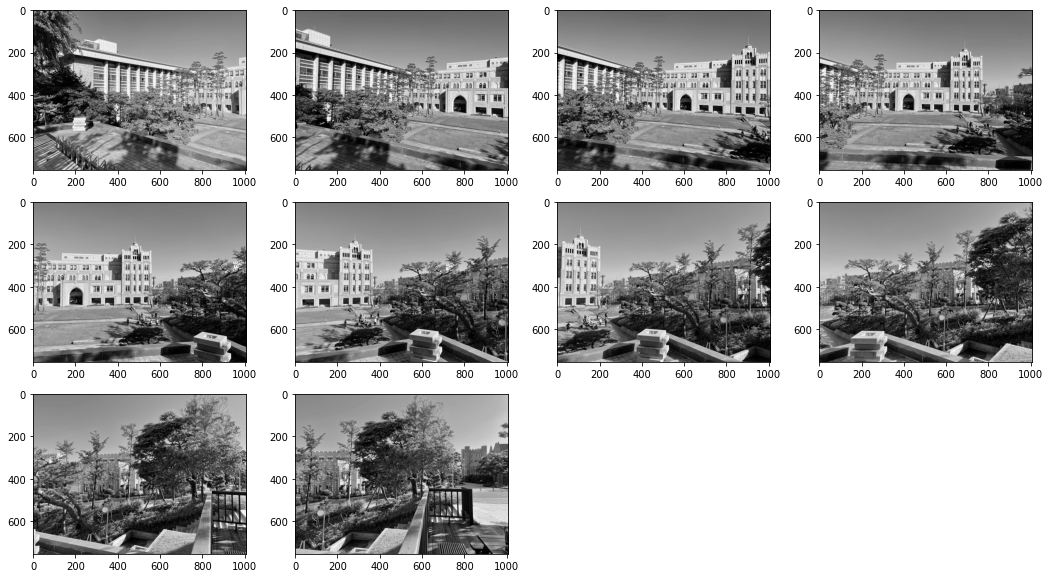

In [20]:
plt.figure(figsize=(18, 10))

for i, img in enumerate(tqdm(images, leave=False)):
    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray')
plt.show()

### Divide Left side images and Right side images

In [21]:
center_id = int(len(images)//2+1)

right_images = images[center_id-1:]

left_images = []

for i, img in enumerate(list(reversed(images[:center_id]))):
    left_images.append(np.flip(img))

### getFeaturePoints

In [ ]:
left_fps = getFeaturePoints(left_images, winSize=5, threshold=0.8)
right_fps = getFeaturePoints(right_images, winSize=5, threshold=0.8)

We wrote some code to plot into the function, but we wrote and visualized the plotting code separately to rotate the left image.

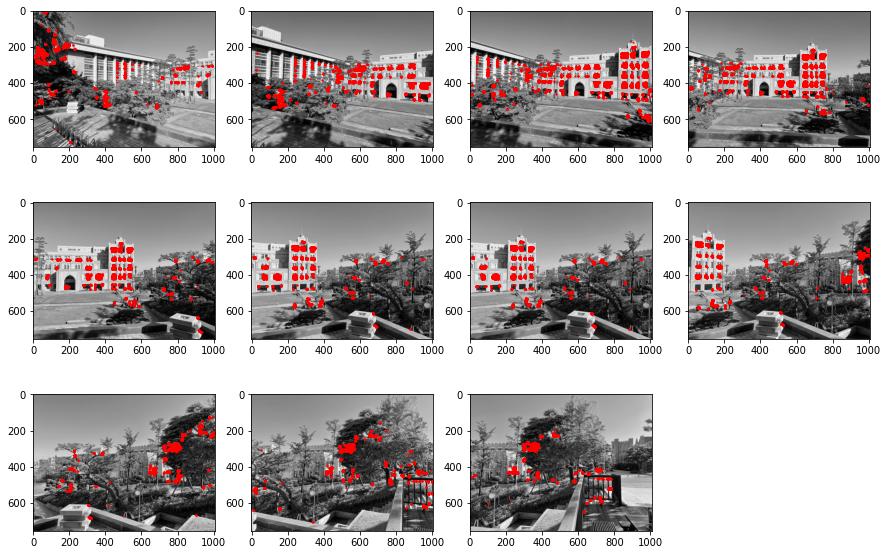

In [23]:
plt.figure(figsize=(15, 10))
    
for i, img in enumerate(reversed(left_images)):
    herris_cor_x = left_fps[len(left_fps)-i-1][:,1]
    herris_cor_y = left_fps[len(left_fps)-i-1][:,0]
        
    plt.subplot(len(images)//5+1, 4, i+1)
    plt.imshow(np.flip(img), cmap='gray')
    plt.scatter(img.shape[1]-herris_cor_x, img.shape[0]-herris_cor_y, color='red', s=1)
    
for i, img in enumerate(right_images):
    herris_cor_x = right_fps[i][:,1]
    herris_cor_y = right_fps[i][:,0]
        
    plt.subplot(len(images)//5+1, 4, len(left_images)+i+1)
    plt.imshow(img, cmap='gray')
    plt.scatter(herris_cor_x, herris_cor_y, color='red', s=1)
plt.show()

### getFeatureDescriptors

In [25]:
left_descriptors = getFeatureDescriptors(left_fps, left_images)
right_descriptors = getFeatureDescriptors(right_fps, right_images)

### match2Images

In [58]:
left_matching_points = match2Images(left_images, left_fps, left_descriptors, threshold=0.96, method='corr')
right_matching_points = match2Images(right_images, right_fps, right_descriptors, threshold=0.96, method='corr')

We wrote some code to plot into the function, but we wrote and visualized the plotting code separately to rotate the left image.

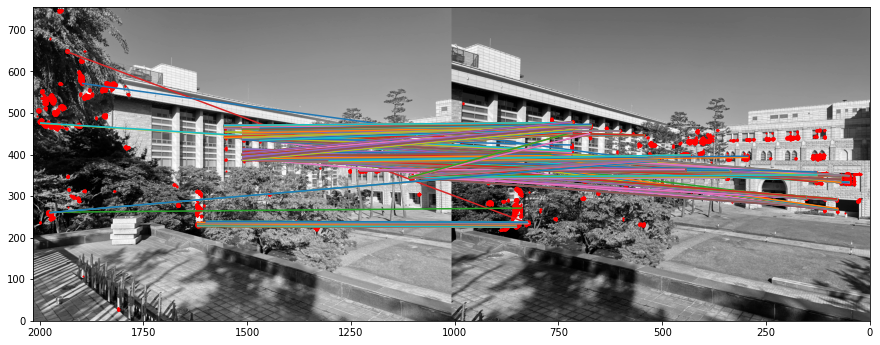

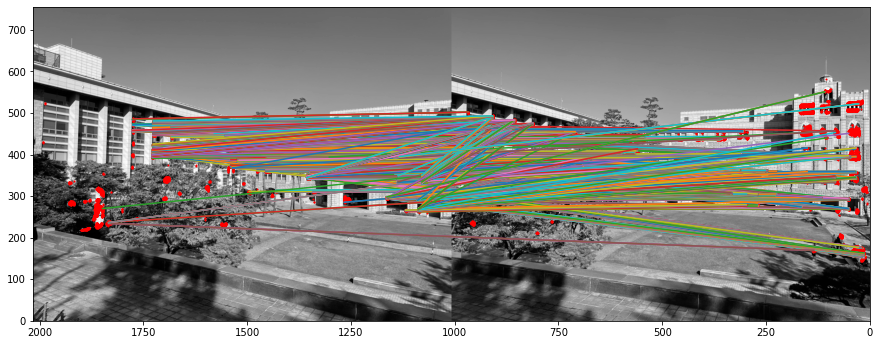

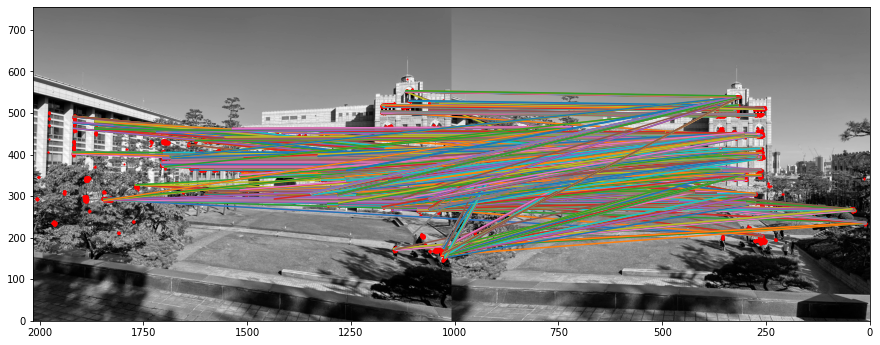

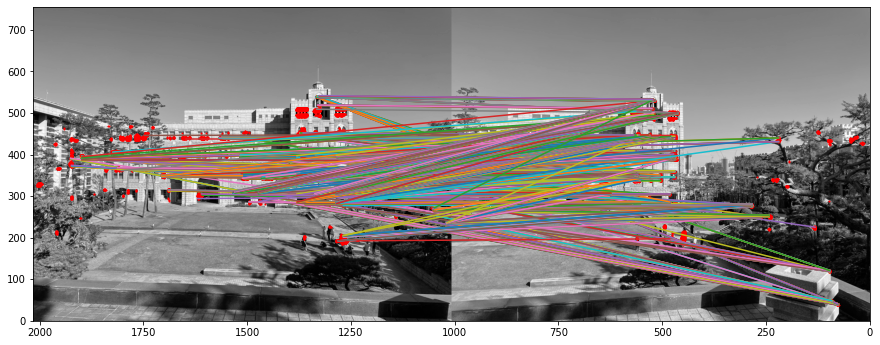

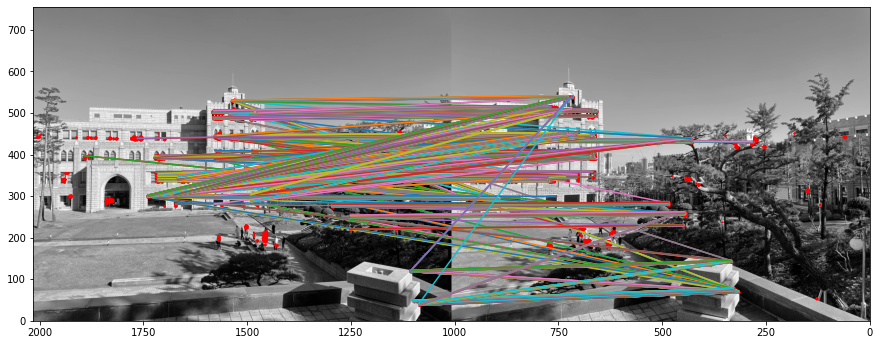

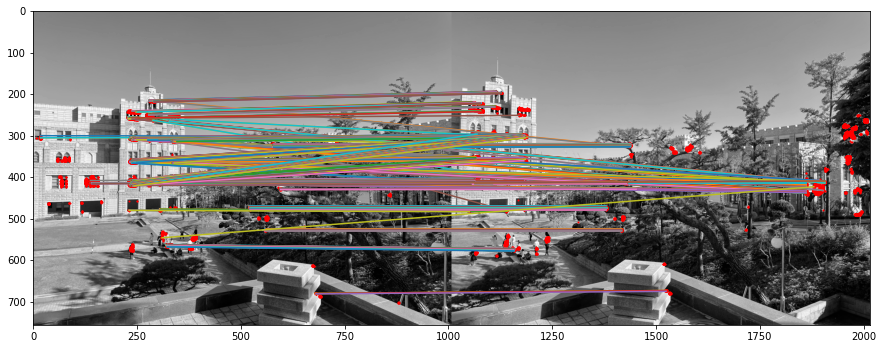

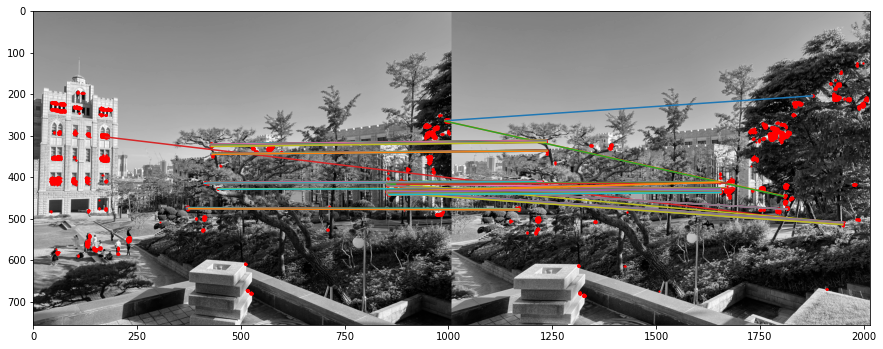

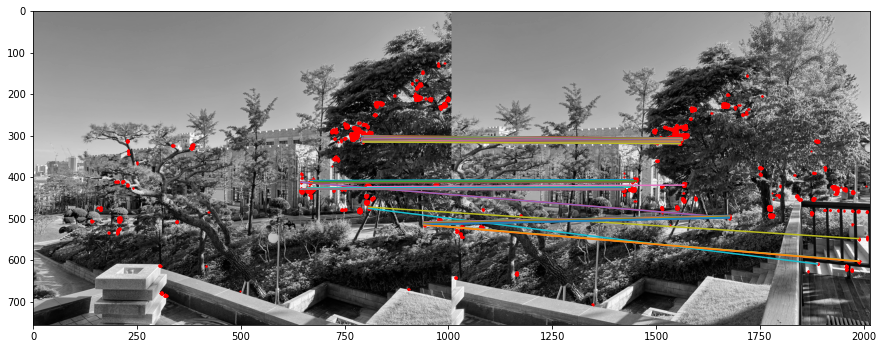

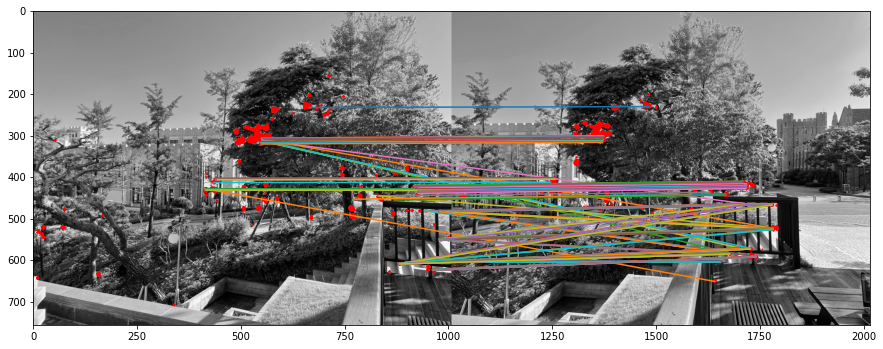

In [72]:
for i in range(len(left_images)-1):
    plt.figure(figsize=(15, 10))
    img1 = left_images[-i-2]
    img2 = left_images[-i-1]
    plt.imshow(np.hstack([img1, img2]), cmap='gray')

    plt.scatter(left_fps[-i-2][:,1], left_fps[-i-2][:,0], color='red', s=1)
    plt.scatter(left_fps[-i-1][:,1]+img2.shape[1], left_fps[-i-1][:,0], color='red', s=1)

    for mat in left_matching_points[-i-1]:
        plt.plot([mat[0].item(3), mat[0].item(1)+images[0].shape[1]], 
                 [mat[0].item(2), mat[0].item(0)])     
        
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.show()    
    
for i in range(len(right_images)-1):
    plt.figure(figsize=(15, 10))
    img1 = right_images[i]
    img2 = right_images[i+1]
    plt.imshow(np.hstack([img1, img2]), cmap='gray')

    plt.scatter(right_fps[i][:,1], right_fps[i][:,0], color='red', s=1)
    plt.scatter(right_fps[i+1][:,1]+img2.shape[1], right_fps[i+1][:,0], color='red', s=1)

    for mat in right_matching_points[i]:
        plt.plot([mat[0].item(3), mat[0].item(1)+images[0].shape[1]], 
                 [mat[0].item(2), mat[0].item(0)])        

    plt.show()

### refineMatches

In [59]:
left_rms = refineMatches(left_matching_points)
right_rms = refineMatches(right_matching_points)

D : 0.48711439266154366, sx : 0.8182307660791472, sy : 0.6261006461769391, P : 0.00036290981574269764
mathing success!
D : 0.5388902638918404, sx : 0.8687139397482165, sy : 0.6310475987800664, P : 0.0003652940609760613
mathing success!
D : 0.6714032894864036, sx : 0.9059647900280314, sy : 0.7467640907151643, P : 0.0002817278851957957
mathing success!
D : 0.5209350324048283, sx : 0.8409868608864127, sy : 0.6385174503406938, P : 0.0003672511639144109
mathing success!
D : 0.580822525778086, sx : 0.8512196356192128, sy : 0.6940840412169932, P : 0.00030983475675181035
mathing success!



D : 0.24714119516005997, sx : 0.6965071007610745, sy : 0.6225233513488463, P : 0.0006827191443402931
mathing success!
D : 0.6427754754066984, sx : 0.7908011526227985, sy : 0.8174268051473069, P : 0.0001910856672979432
mathing success!
D : 0.5347173741378859, sx : 0.8122954031236601, sy : 0.6704350963547148, P : 0.0003066807059754056
mathing success!
D : 0.6352489708200524, sx : 0.8667684440912311, sy : 0.740711754534222, P : 0.0002671284722272048
mathing success!



### warpImages

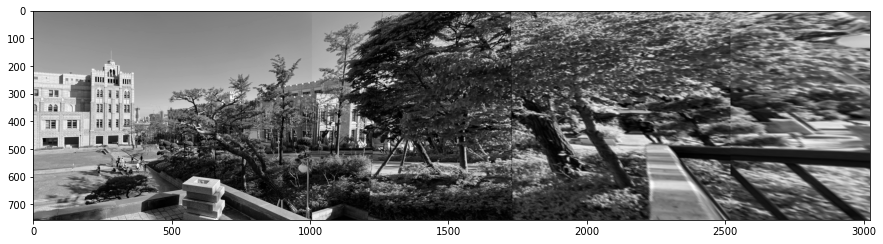

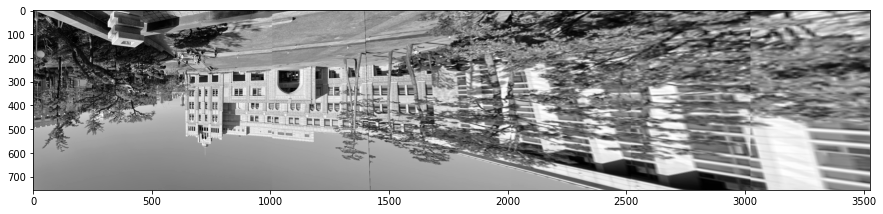

In [91]:
right_result = warpImages(right_images, right_rms)
left_result = warpImages(left_images, left_rms)

### Merge left side images, right side images

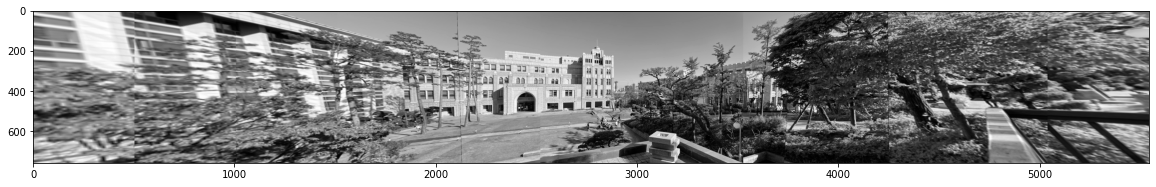

In [82]:
result = np.hstack([np.flip(left_result)[:,:-images[center_id].shape[1]], np.array(right_result)])
plt.figure(figsize=(20, 15))
plt.imshow(result, cmap='gray')
plt.show()

## Test (ED)

### match2Images

In [75]:
left_matching_points_ED = match2Images(left_images, left_fps, left_descriptors, threshold=0.96, method='ED', plot=True)
right_matching_points_ED = match2Images(right_images, right_fps, right_descriptors, threshold=0.96, method='ED', plot=True)

In [ ]:
for i in range(len(left_images)-1):
    plt.figure(figsize=(15, 10))
    img1 = left_images[-i-2]
    img2 = left_images[-i-1]
    plt.imshow(np.hstack([img1, img2]), cmap='gray')

    plt.scatter(left_fps[-i-2][:,1], left_fps[-i-2][:,0], color='red', s=1)
    plt.scatter(left_fps[-i-1][:,1]+img2.shape[1], left_fps[-i-1][:,0], color='red', s=1)

    for mat in left_matching_points_ED[-i-1]:
        plt.plot([mat[0].item(3), mat[0].item(1)+images[0].shape[1]], 
                 [mat[0].item(2), mat[0].item(0)])     
        
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.show()    
    
for i in range(len(right_images)-1):
    plt.figure(figsize=(15, 10))
    img1 = right_images[i]
    img2 = right_images[i+1]
    plt.imshow(np.hstack([img1, img2]), cmap='gray')

    plt.scatter(right_fps[i][:,1], right_fps[i][:,0], color='red', s=1)
    plt.scatter(right_fps[i+1][:,1]+img2.shape[1], right_fps[i+1][:,0], color='red', s=1)

    for mat in right_matching_points_ED[i]:
        plt.plot([mat[0].item(3), mat[0].item(1)+images[0].shape[1]], 
                 [mat[0].item(2), mat[0].item(0)])        

    plt.show()

### refineMatches

In [73]:
ransac(left_matching_points_ED, 1000, thresh=0.08)

KeyboardInterrupt: 

In [60]:
left_rms_ED = refineMatches(left_matching_points_ED, rule=False)
right_rms_ED = refineMatches(right_matching_points_ED, rule=False)

Process ForkPoolWorker-158:
Process ForkPoolWorker-159:
Process ForkPoolWorker-160:
Process ForkPoolWorker-156:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-153:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args,

KeyboardInterrupt: 

### warpImages

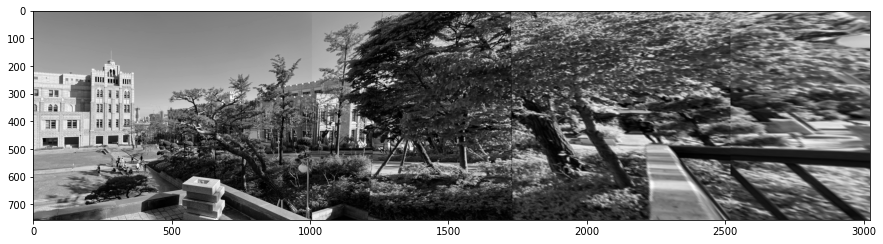

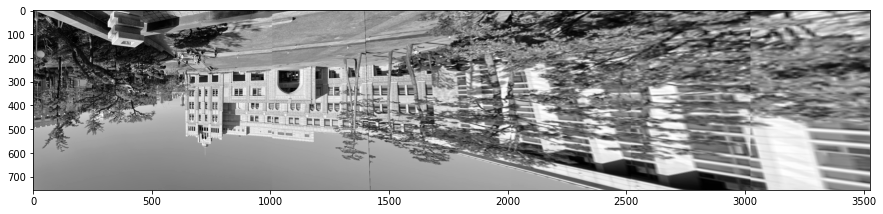

In [91]:
right_result_ED = warpImages(right_images, right_rms_ED)
left_result_ED = warpImages(left_images, left_rms_ED)

### Merge left side images, right side images

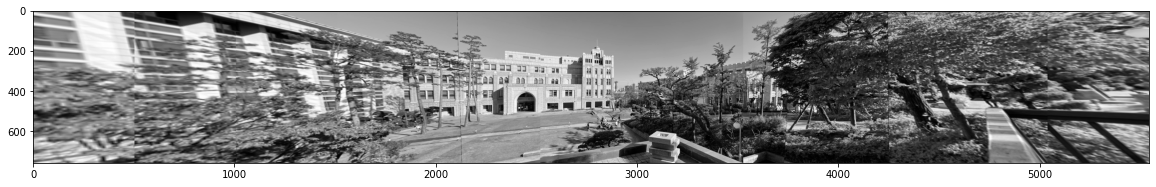

In [82]:
result_ED = np.hstack([np.flip(left_result_ED)[:,:-images[center_id].shape[1]], np.array(right_result_ED)])
plt.figure(figsize=(20, 15))
plt.imshow(result_ED, cmap='gray')
plt.show()

---

In [ ]:
winSize = 16
num_rows, num_cols = images[0].shape
halfSize = int(winSize/2)
    
for i, img in enumerate(reversed(left_images)):
    padding_img = np.zeros((num_rows+winSize, num_cols+winSize))
    padding_img[halfSize:-halfSize, halfSize:-halfSize] = img
    herris_cor_x = left_fps[len(left_fps)-i-1][:,1]
    herris_cor_y = left_fps[len(left_fps)-i-1][:,0]
        
    plt.subplot(len(images)//5+1, 4, i+1)
    plt.imshow(np.flip(img), cmap='gray')
    plt.scatter(img.shape[1]-herris_cor_x, img.shape[0]-herris_cor_y, color='red', s=1)
    for f in left_fps[0]:
    plt.gca().patch(mpl.patches.Rectangle(
        (img.shape[1]-f[1], img.shape[0]-f[0]),
        winSize,
        winSize,
        edgecolor = 'blue',
        fill = False
    ))
    
for i, img in enumerate(right_images):
    padding_img = np.zeros((num_rows+winSize, num_cols+winSize))
    padding_img[halfSize:-halfSize, halfSize:-halfSize] = img
    herris_cor_x = right_fps[i][:,1]
    herris_cor_y = right_fps[i][:,0]
        
    plt.subplot(len(images)//5+1, 4, len(left_images)+i+1)
    plt.imshow(img, cmap='gray')
    plt.scatter(herris_cor_x, herris_cor_y, color='red', s=1)
    for f in right_fps[0]:
    plt.gca().patch(mpl.patches.Rectangle(
        (f[1], if[0]),
        winSize,
        winSize,
        edgecolor = 'blue',
        fill = False
    ))
plt.show()